In [1]:
import os
import sys
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

In [2]:
base_path = os.environ['HOME'] + '/cifar100/AdaNet'
if os.path.isdir(base_path):
  pass
else:
  os.mkdir(base_path)

In [3]:
data = tf.keras.datasets.cifar100.load_data()

train = data[0]
test = data[1]

train_image, train_label = train[0].astype(np.float32), train[1]
test_image, test_label= test[0].astype(np.float32), test[1]

train_label = np.reshape(train_label, newshape=[-1])
test_label = np.reshape(test_label, newshape=[-1])

In [4]:
# Generate Dataset obj   
dataset_obj = tf.data.Dataset.from_tensors(
    {'image': train_image, 'label': train_label})
dataset_obj = dataset_obj.shuffle(50000)
dataset_obj = dataset_obj.unbatch()

# split train-validation dataset
train_dataset = dataset_obj.take(40000)
val_dataset = dataset_obj.skip(40000).take(10000)

test_dataset = tf.data.Dataset.from_tensors(
  {'image': test_image, 'label': test_label})
test_dataset = test_dataset.shuffle(10000).unbatch()

def _preprocessing(dataset, train_mode):
  """
  While train steps, image will be padded random crop and filped(horizontaly)
  And entire steps, per-pixel mean subtracted will be required.
  Args:
    dataset: 'tf.data.Dataset'
    train_mode: 'bool'
  Returns:
    'tf.data.Dataset'
  """
  if train_mode:
    image = dataset['image']
    pad = tf.constant([[2, 2], [2, 2], [0, 0]])
    image = tf.pad(
      tensor=image, paddings=pad)
    image = tf.image.random_crop(
      value=image, size=[32, 32, 3])
    image = tf.image.random_flip_left_right(image=image)
  else:
    image = dataset['image']
    
  image = tf.math.subtract(
    x=image,
    y=tf.reshape(
      tf.math.reduce_mean(image, axis=2), shape=[32, 32, 1]))
  label = dataset['label']
  return (image, label)

train_dataset = train_dataset.map(
  lambda x: _preprocessing(x, train_mode=True))
val_dataset = val_dataset.map(
  lambda x: _preprocessing(x, train_mode=False))
test_dataset = test_dataset.map(
  lambda x: _preprocessing(x, train_mode=False))


train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

In [5]:
# WEAK LEARNER 
def residual_block_tensor(x):
  identity_x = x
  identity_x = keras.layers.Conv2D(
    filters=256, kernel_size=[1, 1], strides=1, padding='same')(identity_x)
  identity_x = keras.layers.BatchNormalization()(identity_x)
  identity_x = keras.layers.ReLU()(identity_x)
  
  x = keras.layers.Conv2D(
    filters=64, kernel_size=[1, 1], strides=1, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)

  x = keras.layers.Conv2D(
    filters=64, kernel_size=[3, 3], strides=1, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  
  x = keras.layers.Conv2D(
    filters=256, kernel_size=[1, 1], strides=1, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  
  x = keras.layers.Add()([x, identity_x])
  x = keras.layers.ReLU()(x)
  return x


# residual block custom layer
class ResidualBlock(keras.layers.Layer):
  def __init__(self, constraint, **kwargs):
    """
    Args:
      constraint(int): Max constraint for variable. (upper lambda)
    """
    super(ResidualBlock, self).__init__()
    self.conv_idt = keras.layers.Conv2D(
      filters=3, kernel_size=[1, 1],
      strides=1, padding='same', name='ConvIdt',
      kernel_constraint=keras.constraints.MaxNorm(constraint))
    self.bn_idt = keras.layers.BatchNormalization()
    self.relu_idt = keras.layers.ReLU()
    
    self.conv_1 = keras.layers.Conv2D(
      filters=64, kernel_size=[1, 1],
      strides=1, padding='same', name='Conv1',
      kernel_constraint=keras.constraints.MaxNorm(constraint))
    self.bn_1 = keras.layers.BatchNormalization()
    self.relu_1 = keras.layers.ReLU()
    
    self.conv_2 = keras.layers.Conv2D(
      filters=64, kernel_size=[1, 1],
      strides=1, padding='same', name='Conv2',
      kernel_constraint=keras.constraints.MaxNorm(constraint))
    self.bn_2 = keras.layers.BatchNormalization()
    self.relu_2 = keras.layers.ReLU()
    
    self.conv_3 = keras.layers.Conv2D(
      filters=3, kernel_size=[1, 1],
      strides=1, padding='same', name='Conv3',
      kernel_constraint=keras.constraints.MaxNorm(constraint))
    self.bn_3 = keras.layers.BatchNormalization()
    self.relu_3 = keras.layers.ReLU()
    
    self.add_last = keras.layers.Add()
    self.relu_last = keras.layers.ReLU()
    
  def call(self, inputs):
    idt_x = self.conv_idt(inputs)
    idt_x = self.bn_idt(idt_x)
    idt_x = self.relu_idt(idt_x)
    x = self.conv_1(inputs)
    x = self.bn_1(x)
    x = self.relu_1(x)
    x = self.conv_2(x)
    x = self.bn_2(x)
    x = self.relu_2(x)
    x = self.conv_3(x)
    x = self.bn_3(x)
    x = self.relu_3(x)
    x = self.add_last([x, idt_x])
    return self.relu_last(x)

In [6]:
class AdaNetLoss(keras.losses.Loss):
  
  def __init__(self, 
               weight, 
               num_outputs, 
               batch_size, 
               num_classes,
               name='weighted_loss'):
    super(AdaNetLoss, self).__init__()
    self.weight = weight
    self.num_outputs = num_outputs
    self.batch_size = batch_size
    self.num_classes = num_classes

  def call(self, y_true, y_pred):
    weighted_pred = tf.tensordot(
      tf.reshape(self.weight, shape=[self.num_outputs, 1]),
      tf.reshape(
        y_pred, shape=[self.num_outputs, self.batch_size, self.num_classes]),
      axes=[[0], [0]])
    weighted_pred_mean = tf.math.multiply(
      weighted_pred, 1/self.num_outputs)
    
    loss = tf.keras.losses.categorical_crossentropy(
      y_true=y_true,
      y_pred=weighted_pred_mean)
    
    loss_without_nan = tf.where(
      tf.math.is_nan(loss), tf.zeros_like(loss), loss)
    print(loss_without_nan)
    print(tf.reduce_sum(loss_without_nan))
    return tf.reduce_sum(loss_without_nan)

### 만들어야 할것
1. keras.Model object (모델에 Loss까지 정의 되어야 하는가..?)
    * Args (\__init__에 들어가는 것)
        - base classifier 의 층 수 <U>이건 어떻게 처리할 것인가 for loop로 layer를 쌓는가?</U>
        (그리고 각 층별로 logit이 나와야 층별로 나온 logit을 바탕으로 weighted loss를 구할 수 있으니깐..)
        - for loop를 돌리면서 하도록 하고.. outputs에 대한 비어있는 list를 먼저 만들어서(층 수는 미리 파악하면 되니깐) 각 list의 element에 결과로 나온 logit을 할당해주면 되겠다
    * Returns ( call 에 들어가는 것)
        - Logit이 필요한데.. 각 층별 Logit이 필요 

keras.Model subclassing이 과연 필요한가?
- 각 층별로 logit이 나오고, 그 logit들을 바탕으로 weighted loss를 구해야함.

In [7]:
# custom model 에서는
# layer의 갯수를 입력으로 받고 
# output으로는 weighted loss값을 빼낸다.
# custom model 에서 loss를 넣어주자 (나중에 뽑아 쓸수 있도록)


```python
class AdaResNet(keras.Model):
  def __init__(self,
               num_layer,
               name='adaresnet',
               **kwargs):
    super(AdaResNet, self).__init__(name=name, **kwargs)
    self.num_layer = num_layer
    
  def call(self, inputs):
    output_list = [
      "output_" + str(x) for x in list(range(1, self.num_layer+1))]
    x = inputs
    for i in range(self.num_layer):
      x = ResidualBlock(constraint=2)(x)
      _output = keras.layers.GloablAveragePooing2D()(x)
      _output = keras.layers.Dense(100, name=output_list[i])(_output)
      output_list[i] = _output
    
    return output_list
```

In [8]:
#train_data, label = next(iter(train_dataset.batch(100)))
#oh_label = tf.one_hot(label, depth=100)


In [9]:
# AdaNet에서 layer를 쌓아가는 방식

NUM_OF_LAYERS = 5

inputs = keras.Input(shape=[32, 32, 3], name='img1')

if NUM_OF_LAYERS==0:
  x = inputs
  _output = keras.layers.GlobalAveragePooling2D()(x)
  _output = keras.layers.Dense(100, name="first_iter_output")(_output)
  output_list = [_output]
else:
  output_list = ["output_" + str(x) for x in list(range(1, NUM_OF_LAYERS+1))]
  x = inputs
  for i in range(NUM_OF_LAYERS):
    x = ResidualBlock(constraint=2)(x)
    _output = keras.layers.GlobalAveragePooling2D()(x)
    _output = keras.layers.Dense(100, name=output_list[i])(_output)
    output_list[i] = _output
    
model = keras.Model(inputs=inputs, outputs=output_list)

# weighted loss값이 어떤지 봐야하니깐
# pred, true를 비교해줘야겠지
weight = tf.Variable(
  tf.ones(shape=[NUM_OF_LAYERS], dtype=tf.float32),
  trainable=True, name='Weight')

optimizer = tf.keras.optimizers.Adam()

In [ ]:
## model.fit으로 학습시키자..

adanetloss = AdaNetLoss(
        weight=weight, 
        num_outputs=NUM_OF_LAYERS,
        batch_size=100,
        num_classes=100)

In [10]:
adanetloss = AdaNetLoss(
        weight=weight, 
        num_outputs=NUM_OF_LAYERS,
        batch_size=100,
        num_classes=100)

for epoch in range(3):
  print('Start of epoch {}'.format(epoch+1))
  
  for step, x_batch_train in enumerate(train_dataset.batch(100)):
    with tf.GradientTape() as tape:
      
      expected = tf.one_hot(x_batch_train[1], depth=100)
      predicted = model(x_batch_train[0])
      """
      weighted_predicted = tf.tensordot(
        tf.reshape(weight, shape=[5, 1]),
        tf.reshape(predicted, shape=[5, 100, 100]), axes=[[0], [0]])
      
      weighted_pred_mean = tf.math.multiply(
        weighted_predicted, 1/len(weighted_predicted))
      
      #print(tf.math.reduce_mean(weighted_pred_mean, axis=0))
      #print(expected)
      
      loss = tf.keras.losses.categorical_crossentropy(
        y_true=expected,
        y_pred=tf.math.reduce_mean(predicted, axis=0))

      loss = loss_metric(loss)
      """
      loss = adanetloss(expected, predicted)
      #print(loss)
      
    train_list = model.trainable_weights
    train_list.append(weight)
    
    grads = tape.gradient(loss, train_list)
    #print(grads)
    optimizer.apply_gradients(zip(grads, train_list))
    
    
    if step % 100 == 0:
      print("step {}: loss= {}".format(step, loss))

Start of epoch 1
tf.Tensor(
[[16.118095   2.9371088 16.118095  16.118095  16.118095   3.9599874
   2.8232362 16.118095   5.206488   2.9089415  3.1885839  0.
   3.60108    3.7968016  3.962757   2.553859  16.118095   2.9172077
   2.4682164  3.9466531  1.8105428 16.118095   7.756285  16.118095
  16.118095   2.3850057 16.118095   2.1971176  2.7807946 16.118095
  16.118095   4.230486   2.1174421  2.6368003 16.118095  16.118095
  16.118095  16.118095  16.118095   2.2785923  2.0040264 16.118095
   6.297841   2.1944757 16.118095   3.8360257 16.118095   2.696613
  16.118095   1.9790372  4.980382  16.118095  16.118095   2.2347324
   3.5366406 16.118095   2.068073   5.0817366 16.118095   2.2370431
   2.2041352  2.9119291  3.2456284  3.9178157 16.118095  16.118095
  16.118095  16.118095   2.974377   4.4356985  3.0627563 16.118095
  16.118095  16.118095   2.3910856  4.1546845 16.118095  16.118095
  16.118095   2.9117332  2.5411854 16.118095   4.9299655 16.118095
   5.483402   2.4447718 16.118095  1

KeyboardInterrupt: 

In [ ]:
# loss 자체를 kears custom loss로 만들어보자

In [ ]:
expected = tf.one_hot(x_batch_train[1], depth=100)
predicted = model(x_batch_train[0])

weighted_predicted = tf.tensordot(
  tf.reshape(weight, shape=[5, 1]),
  tf.reshape(predicted, shape=[5, 100, 100]), axes=[[0], [0]])

weighted_pred_mean = tf.math.multiply(
  weighted_predicted, 1/len(weighted_predicted))

#print(tf.math.reduce_mean(weighted_pred_mean, axis=0))
#print(expected)

loss = tf.keras.losses.categorical_crossentropy(
  y_true=expected,
  y_pred=tf.math.reduce_mean(predicted, axis=0))

loss = loss_metric(loss)



In [16]:
weight.shape[0]

5

In [20]:
## trainable_weights를 구하려는 것은 Rademacher Complexity의 
## upper bound 를 계산하기 위해 weight 와 unit size를 구하는 것이 필요하다

# keras.Model subclassing 해서 하도록 하자.. 해당 subclassing된 Model object에는 
# weight * outputs_list까지 포함하게 한다. 

weights_list = model.trainable_weights
weights_list = [x for x in weights_list if 'Conv' in x.name]
weights_list = [x for x in weights_list if 'kernel:0' in x.name]
normed_weights_list = [tf.norm(tensor=x, ord=2) for x in weights_list]

output_units = 32*32*3*3 # 이것이 1층 layer hypothesis의 N을 나타냄

In [21]:
# 여기서 계산한 weights_list의 각 weights별 l2_norm을 
np.prod(normed_weights_list)

1.0

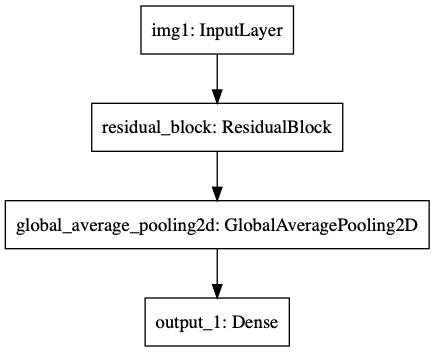

In [26]:
keras.utils.plot_model(model, 'my_first_model.png')

In [6]:
# PARAMS
NUM_ITER = 30

# Use tf.Variable contraint 
UPPER_LAMBDA = 1
LOWER_LAMBDA = 0
BETA = 0

In [7]:
# Surrogate loss로는 cross entropy를 사용

In [8]:
inputs = keras.Input(shape=[32, 32, 3], name='img1')

x = ResidualBlock(2)(inputs)
temp_x2 = keras.layers.GlobalAveragePooling2D()(x)
temp_output = keras.layers.Dense(100)(temp_x2)

x = ResidualBlock(2)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(100)(x)

In [9]:
model = keras.Model(inputs=inputs, outputs=[temp_output, output])

In [10]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='Adam')

In [17]:
from tensorflow.keras import layers
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=32,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dense_proj(inputs)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_output = layers.Dense(original_dim, activation='sigmoid')

  def call(self, inputs):
    x = self.dense_proj(inputs)
    return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               latent_dim=32,
               name='autoencoder',
               **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss)
    return reconstructed


original_dim = 784
vae = VariationalAutoEncoder(original_dim, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      loss = mse_loss_fn(x_batch_train, reconstructed)
      loss += sum(vae.losses)  # Add KLD regularization loss

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 100 == 0:
      print('step %s: mean loss = %s' % (step, loss_metric.result()))
      print('vae losses{}'.format(vae.losses))

Start of epoch 0
step 0: mean loss = tf.Tensor(0.3169254, shape=(), dtype=float32)
vae losses[<tf.Tensor: id=527570, shape=(), dtype=float32, numpy=0.08047132>]
step 100: mean loss = tf.Tensor(0.12541005, shape=(), dtype=float32)
vae losses[<tf.Tensor: id=546488, shape=(), dtype=float32, numpy=0.00065419014>]
step 200: mean loss = tf.Tensor(0.09926062, shape=(), dtype=float32)
vae losses[<tf.Tensor: id=565191, shape=(), dtype=float32, numpy=5.6293735e-05>]
step 300: mean loss = tf.Tensor(0.08921422, shape=(), dtype=float32)
vae losses[<tf.Tensor: id=583894, shape=(), dtype=float32, numpy=5.96678e-06>]
step 400: mean loss = tf.Tensor(0.08425562, shape=(), dtype=float32)
vae losses[<tf.Tensor: id=602597, shape=(), dtype=float32, numpy=3.6250567e-06>]
step 500: mean loss = tf.Tensor(0.080906875, shape=(), dtype=float32)
vae losses[<tf.Tensor: id=621300, shape=(), dtype=float32, numpy=9.570795e-07>]
step 600: mean loss = tf.Tensor(0.078771226, shape=(), dtype=float32)
vae losses[<tf.Tensor

KeyboardInterrupt: 

In [16]:
loss

<tf.Tensor: id=527266, shape=(), dtype=float32, numpy=0.06794694>

In [15]:
vae.losses

[<tf.Tensor: id=527243, shape=(), dtype=float32, numpy=6.146729e-07>]